<a href="https://colab.research.google.com/github/OscarLeoSanchez/prediccion-pastos-antioquia/blob/main/proyecto_optimizacion_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install Optuna

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import json

In [ ]:
data = pd.DataFrame()
try:
  data = pd.read_csv('/content/gdrive/Shareddrives/Especialización IA/Optimización e IA/Trabajo /data.csv')
except:
  data = pd.read_csv('data.csv')
data

,AÑO,SUBREGION,RUBRO,MUNICIPIO,BOVINOS Cría Macho (< DE 12),BOVINOS Novillo Levante (12-24),BOVINOS Novillo Ceba ( 24-36),BOVINOS Toros (> 36),TOTAL MACHOS,BOVINOS Cría Hembra (< DE 12),...,BOVINOS Novilla Vientre ( 24-36),BOVINOS Vaca (> 36),TOTAL HEMBRAS,Total Bovinos,Pasto Corte (ha),Pasto Natural (ha),Pasto Mejorado (ha),Pasto Forrajero (ha),Silvopastoril (ha),Total Pastos (ha)
0,2000,Bajo Cauca,BOVINOS,CÁCERES,5923.0,7561.0,10068.0,2605.0,26157,9071.0,...,7965.0,28100.0,55122,81279.0,4500.0,68500.0,20000.0,NaN,NaN,93000.0
1,2000,Bajo Cauca,BOVINOS,CAUCASIA,8257.0,17329.0,15671.0,2210.0,43467,12646.0,...,12932.0,44489.0,86616,130083.0,120.0,80300.0,25000.0,NaN,NaN,105420.0
2,2000,Bajo Cauca,BOVINOS,EL BAGRE,564.0,596.0,242.0,165.0,1567,864.0,...,1374.0,2176.0,5400,6967.0,NaN,28350.0,8000.0,NaN,NaN,36350.0
3,2000,Bajo Cauca,BOVINOS,NECHÍ,2726.0,3092.0,2824.0,880.0,9522,4175.0,...,3361.0,13870.0,24607,34129.0,NaN,31000.0,12500.0,NaN,NaN,43500.0
4,2000,Bajo Cauca,BOVINOS,TARAZÁ,2462.0,6418.0,2656.0,702.0,12238,3770.0,...,2698.0,10434.0,23608,35846.0,NaN,35200.0,NaN,NaN,NaN,35200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,2021,Valle de Aburra,BOVINOS,ENVIGADO,143.0,327.0,75.0,21.0,566,424.0,...,320.0,670.0,1959,2525.0,NaN,883.0,37.0,NaN,10.0,930.0
2597,2021,Valle de Aburra,BOVINOS,GIRARDOTA,616.0,1040.0,861.0,225.0,2742,1111.0,...,1087.0,1772.0,5406,8148.0,209.0,475.0,10.0,5.0,NaN,699.0
2598,2021,Valle de Aburra,BOVINOS,LA ESTRELLA,78.0,228.0,72.0,2.0,380,113.0,...,199.0,143.0,703,1083.0,150.0,450.0,NaN,NaN,NaN,600.0
2599,2021,Valle de Aburra,BOVINOS,MEDELLÍN,835.0,869.0,489.0,101.0,2294,2397.0,...,1840.0,4206.0,11079,13373.0,454.0,2992.0,5529.0,NaN,NaN,8975.0


In [ ]:

no_col = ['RUBRO', 'MUNICIPIO','TOTAL MACHOS','TOTAL HEMBRAS','Total Bovinos','Total Pastos (ha)']
data = data.drop(no_col, axis=1)

# for col in data.columns:
#     if data[col].dtype == 'object' and col != 'SUBREGION':
#         data[col] = data[col].astype(float)

labels = ['Pasto Corte (ha)','Pasto Natural (ha)','Pasto Mejorado (ha)','Pasto Forrajero (ha)','Silvopastoril (ha)']

for col in labels:
    data[col] = data[col].fillna(value=0)

data = data.dropna()

# # data = remove_outliers(data)

# data.isnull().sum(), data.shape
data = data.groupby(['AÑO', 'SUBREGION']).sum().reset_index()
data = data.drop(['AÑO'], axis=1)

## SVR

### No optimizado

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = data.drop(labels, axis=1)
y = data[labels]

categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SVR()))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(mse)
print(mae)

1727484186.2871475
23792.65813473946


### Optimización

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


X = data.drop(labels, axis=1)
y = data[labels]

categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

param_grid = {
    'regressor__estimator__C': [0.1, 1, 10, 100],
    'regressor__estimator__gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
    'regressor__estimator__epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'regressor__estimator__kernel': ['rbf', 'poly', 'sigmoid']
}

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SVR()))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print(f'Best stimator: {grid_search.best_estimator_}')

best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
# y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 924 candidates, totalling 4620 fits
Mejores hiperparámetros: {'regressor__estimator__C': 100, 'regressor__estimator__epsilon': 10, 'regressor__estimator__gamma': 0.1, 'regressor__estimator__kernel': 'poly'}
Best stimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BOVINOS Cría Macho (< DE '
                                                   '12)',
                                                   'BOVINOS Novillo Levante '
                                                   '(12-24)',
                                                   'BOVINOS Novillo  Ceba ( '
                                                   '24-36)',
                                                   'BOVINOS Toros (> 36)',
                                                   'BOVINOS Cría Hembra (< DE '
                                                   '12)',
             

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)

print(f'Best stimator: {grid_search.best_estimator_}')

Mejores hiperparámetros: {'regressor__estimator__C': 100, 'regressor__estimator__epsilon': 10, 'regressor__estimator__gamma': 0.1, 'regressor__estimator__kernel': 'poly'}
Best stimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BOVINOS Cría Macho (< DE '
                                                   '12)',
                                                   'BOVINOS Novillo Levante '
                                                   '(12-24)',
                                                   'BOVINOS Novillo  Ceba ( '
                                                   '24-36)',
                                                   'BOVINOS Toros (> 36)',
                                                   'BOVINOS Cría Hembra (< DE '
                                                   '12)',
                                                   'BOVINOS Novilla Levante (

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Error Cuadrático Medio (MSE):", mse)
print("Error Absoluto Medio (MAE):", mae)

Error Cuadrático Medio (MSE): 1584601418.1322694
Error Absoluto Medio (MAE): 22720.352714997418


## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import optuna

# Crear el modelo con regularización y dropout
def create_cnn_model(size_input, size_output, learning_rate=0.01, dropout_rate=0.2, l2_lambda=0.01):
    model = Sequential()
    # Capa de entrada
    model.add(Dense(64, input_dim=size_input, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Capa oculta
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Capa de salida
    model.add(Dense(size_output, activation='linear'))

    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

# Función para optimizar el modelo con Optuna
def optimize_cnn_model(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-6, 1e-2)

    # Crear y compilar el modelo
    model = create_cnn_model(X_train.shape[1], y_train.shape[1], learning_rate=learning_rate, dropout_rate=dropout_rate, l2_lambda=l2_lambda)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True)

    # Entrenar el modelo
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
    val_error = history.history['val_mae'][-1]
    return val_error

def plot_cnn_history(cnn_history):
  # Gráfica de precisión
  plt.plot(cnn_history.history['mae'])
  plt.plot(cnn_history.history['val_mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

Preparación de los datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preparación y división de los datos
X = data.drop(labels, axis=1)
y = data[labels]

categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesar los datos
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### No optimizado

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

cnn_model = create_cnn_model(X_train.shape[1], y_train.shape[1])
history = cnn_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


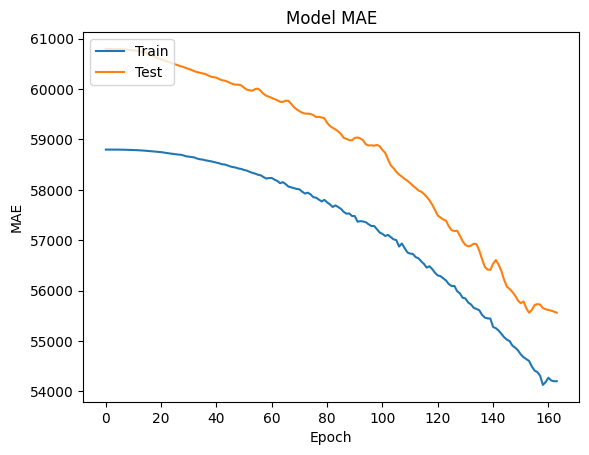

In [ ]:
plot_cnn_history(history)



### Optimizado

In [ ]:
# Optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_cnn_model, n_trials=20)

# Mejor trial
trial = study.best_trial
print('Mejor MAE: {}'.format(trial.value))


[I 2023-11-18 21:49:33,691] A new study created in memory with name: no-name-ab186535-722c-419c-8bf0-50e411a9ef48
[I 2023-11-18 21:54:21,494] Trial 0 finished with value: 15240.7998046875 and parameters: {'learning_rate': 0.0628651709195975, 'dropout_rate': 0.13312869413867157, 'l2_lambda': 0.0005535839747232911}. Best is trial 0 with value: 15240.7998046875.
[I 2023-11-18 22:00:25,544] Trial 1 finished with value: 22547.72265625 and parameters: {'learning_rate': 0.03793161732851853, 'dropout_rate': 0.3690547414682082, 'l2_lambda': 0.004183269449115741}. Best is trial 0 with value: 15240.7998046875.
[I 2023-11-18 22:06:42,510] Trial 2 finished with value: 39815.29296875 and parameters: {'learning_rate': 0.02083718327158358, 'dropout_rate': 0.4304910338317934, 'l2_lambda': 0.0029616469141217055}. Best is trial 0 with value: 15240.7998046875.
[I 2023-11-18 22:10:09,832] Trial 3 finished with value: 28053.748046875 and parameters: {'learning_rate': 0.02573646068266907, 'dropout_rate': 0.3

Mejor MAE: 11552.03515625


In [ ]:
print('Mejor MAE: {}'.format(trial.value))

Mejor MAE: 11552.03515625


In [ ]:
best_params = study.best_params
best_params

{'learning_rate': 0.08083794876357481,
 'dropout_rate': 0.2840811438775757,
 'l2_lambda': 0.004570139352541991}

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

cnn_model = create_cnn_model(X_train.shape[1], y_train.shape[1], **best_params)
history = cnn_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


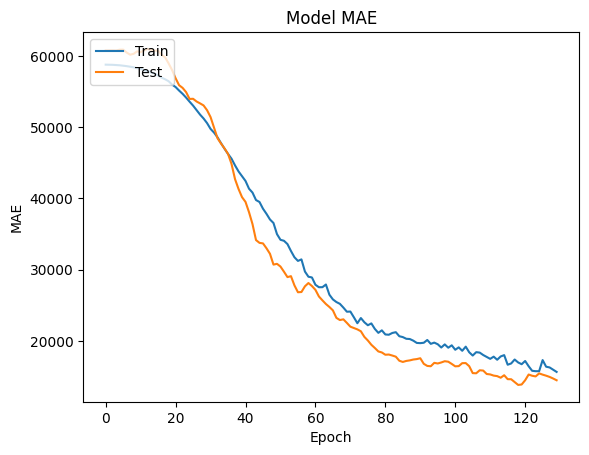

In [ ]:
plot_cnn_history(history)